# 1. Install Dependencies and Setup

In [ ]:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
import tensorflow as tf
import os

# 2. Remove dodgy images

In [ ]:
# import cv2
# import imghdr

In [ ]:
# data_dir = 'data'

In [ ]:
# image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
# for image_class in os.listdir(data_dir):
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try:
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts:
#                 print('Image not in ext list {}'.format(image_path))
#                 os.remove(image_path)
#         except Exception as e:
#             print('Issue with image {}'.format(image_path))
#             # os.remove(image_path)

# 3. Load Data

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/dataaa/tuberculosis')

Found 558 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

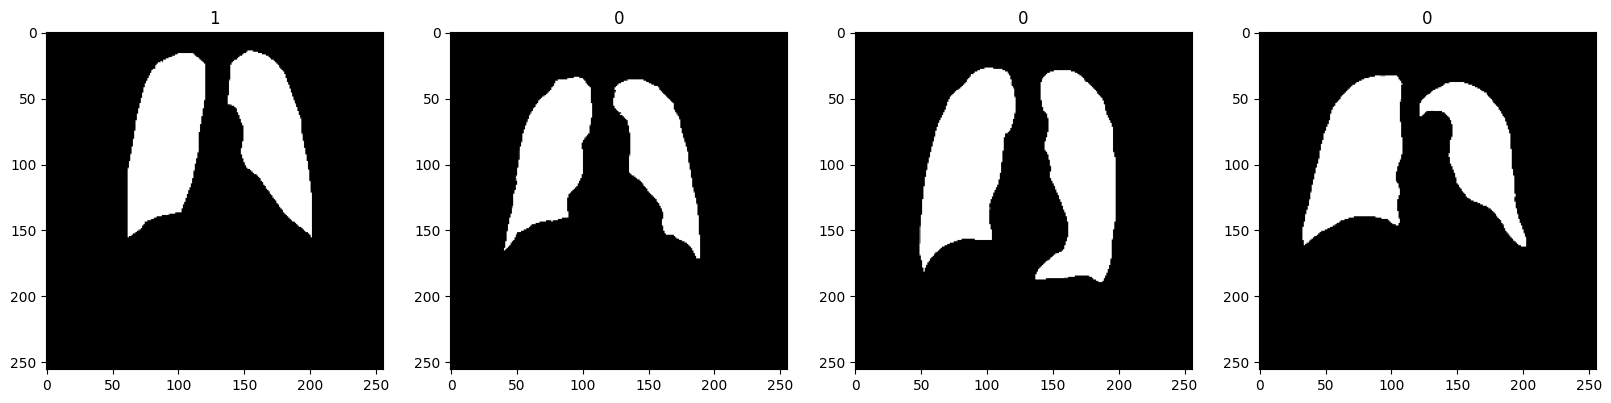

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [ ]:
  batch[0].min()

0.0

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()[0].max()

1.0

# 5. Split Data

In [ ]:
len(data)

18

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.3)
test_size = int(len(data)*.1)

In [ ]:
train_size

12

In [ ]:
val_size

5

In [ ]:
test_size

1

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [ ]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

BN-CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Create a Sequential model
model = Sequential()

# Add convolutional layers with batch normalization and max pooling
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add dropout
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())

# Add dense layers with batch normalization and dropout
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_9 (Bat  (None, 254, 254, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 flatten_2 (Flatten)         (None, 258064)            0         
                                                                 
 dense_5 (Dense)             (None, 32)               

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 64s 4s/step - loss: 1.0059 - accuracy: 0.5755 - val_loss: 1.5656 - val_accuracy: 0.5875
Epoch 2/10
12/12 [==============================] - 79s 6s/step - loss: 0.6068 - accuracy: 0.7135 - val_loss: 0.8990 - val_accuracy: 0.5938
Epoch 3/10
12/12 [==============================] - 79s 6s/step - loss: 0.5408 - accuracy: 0.7552 - val_loss: 0.7409 - val_accuracy: 0.6375
Epoch 4/10
12/12 [==============================] - 79s 6s/step - loss: 0.4659 - accuracy: 0.7786 - val_loss: 0.6081 - val_accuracy: 0.7188
Epoch 5/10
12/12 [==============================] - 66s 5s/step - loss: 0.3720 - accuracy: 0.8672 - val_loss: 0.5302 - val_accuracy: 0.7750
Epoch 6/10
12/12 [==============================] - 79s 6s/step - loss: 0.2488 - accuracy: 0.8958 - val_loss: 0.4935 - val_accuracy: 0.8438
Epoch 7/10
12/12 [==============================] - 79s 6s/step - loss: 0.1911 - accuracy: 0.9297 - val_loss: 0.5296 - val_accuracy: 0.7688
Epoch 8/10
12/12 [==

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in val.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
precision = pre.result().numpy()
recall = re.result().numpy()
accuracy = acc.result().numpy()

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

1/1 [==============================] - 1s 862ms/step
Precision: 1.0
Recall: 0.597561
Accuracy: 0.79375
F1 Score: 0.7480916235595721


12/12 [==============================] - 27s 1s/step


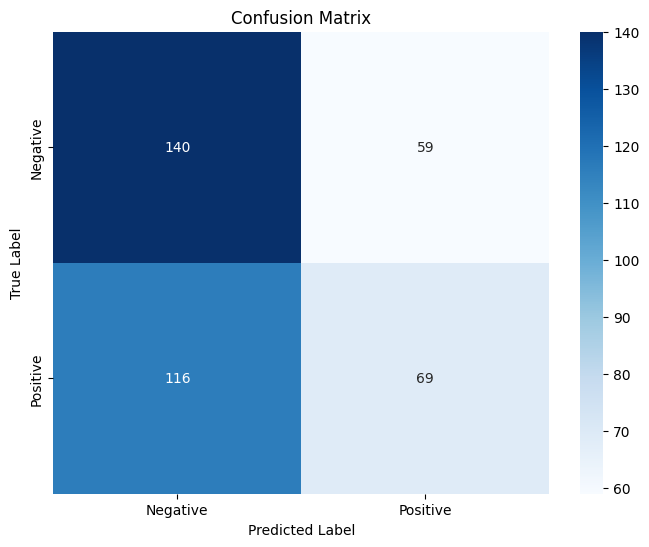

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels for the validation set
true_labels = np.concatenate([y for x, y in train], axis=0)

# Predict labels using the hybrid model on the validation set
predicted_labels = model.predict(train)

# Convert predicted probabilities to binary labels
predicted_labels_binary = np.round(predicted_labels).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


##Basic CNN

In [ ]:
from tensorflow.keras.models import Sequential
model = Sequential()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(16, (3, 3), activation='tanh', input_shape=(256, 256, 3)),
    Conv2D(32, (3, 3), activation='tanh'),
    Conv2D(16, (3, 3), activation='tanh'),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])


In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 conv2d_7 (Conv2D)           (None, 252, 252, 32)      4640      
                                                                 
 conv2d_8 (Conv2D)           (None, 250, 250, 16)      4624      
                                                                 
 flatten_3 (Flatten)         (None, 1000000)           0         
                                                                 
 dropout_1 (Dropout)         (None, 1000000)           0         
                                                                 
 dense_6 (Dense)             (None, 128)               128000128 
                                                                 
 dense_7 (Dense)             (None, 1)                 1

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 176s 13s/step - loss: 3.1465 - accuracy: 0.4766 - val_loss: 3.7915 - val_accuracy: 0.4875
Epoch 2/10
12/12 [==============================] - 170s 13s/step - loss: 3.3463 - accuracy: 0.5182 - val_loss: 2.9133 - val_accuracy: 0.5500
Epoch 3/10
12/12 [==============================] - 168s 13s/step - loss: 2.9762 - accuracy: 0.5052 - val_loss: 2.7106 - val_accuracy: 0.5063
Epoch 4/10
12/12 [==============================] - 170s 13s/step - loss: 2.5951 - accuracy: 0.4844 - val_loss: 2.5128 - val_accuracy: 0.4437
Epoch 5/10
12/12 [==============================] - 158s 12s/step - loss: 2.0876 - accuracy: 0.4870 - val_loss: 1.7500 - val_accuracy: 0.5125
Epoch 6/10
12/12 [==============================] - 168s 13s/step - loss: 1.5348 - accuracy: 0.5182 - val_loss: 1.4904 - val_accuracy: 0.4563
Epoch 7/10
12/12 [==============================] - 168s 13s/step - loss: 1.1582 - accuracy: 0.5208 - val_loss: 1.0481 - val_accuracy: 0.5000
Epoch 

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in val.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
precision = pre.result().numpy()
recall = re.result().numpy()
accuracy = acc.result().numpy()

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

1/1 [==============================] - 2s 2s/step
Precision: 0.50625
Recall: 1.0
Accuracy: 0.50625
F1 Score: 0.6721991911417349


12/12 [==============================] - 46s 3s/step


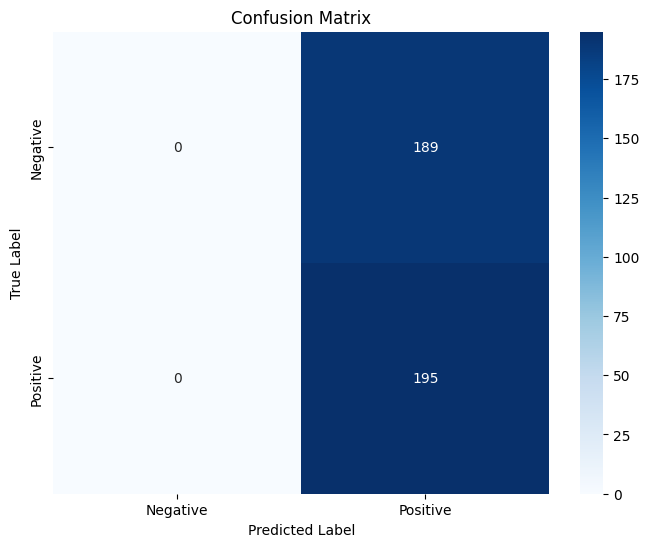

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels for the validation set
true_labels = np.concatenate([y for x, y in train], axis=0)

# Predict labels using the hybrid model on the validation set
predicted_labels = model.predict(train)

# Convert predicted probabilities to binary labels
predicted_labels_binary = np.round(predicted_labels).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


##Dense CNN

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming 256x256 input images
input_shape = (256, 256, 3)

def create_simple_cnn_classification_model_with_high_dropout():
    inputs = Input(input_shape)

    # Simple CNN layers
    conv1 = Conv2D(8, (3, 3), activation='relu')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    flatten = Flatten()(pool1)

    # Dense layers with high dropout
    dense1 = Dense(16, activation='relu')(flatten)
    dropout1 = Dropout(0.8)(dense1)  # Increase dropout rate to 0.8
    output = Dense(1, activation='sigmoid')(dropout1)

    simple_cnn_classification_model_with_high_dropout = Model(inputs, output, name='simple_cnn_classification_model_with_high_dropout')
    return simple_cnn_classification_model_with_high_dropout

# Create the model with high dropout
model_with_high_dropout = create_simple_cnn_classification_model_with_high_dropout()

# Compile the model
model_with_high_dropout.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# # Assuming 256x256 input images
# input_shape = (256, 256, 3)

# def create_small_cnn_classification_model_with_dropout():
#     inputs = Input(input_shape)

#     # Small CNN layers
#     conv1 = Conv2D(16, (3, 3), activation='relu')(inputs)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = Conv2D(32, (3, 3), activation='relu')(pool1)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     flatten = Flatten()(pool2)

#     # Dense layers with dropout
#     dense1 = Dense(64, activation='relu')(flatten)
#     dropout1 = Dropout(0.5)(dense1)  # Add dropout with rate 0.5
#     output = Dense(1, activation='sigmoid')(dropout1)

#     small_cnn_classification_model_with_dropout = Model(inputs, output, name='small_cnn_classification_model_with_dropout')
#     return small_cnn_classification_model_with_dropout

# # Create the model with dropout
# model_with_dropout = create_small_cnn_classification_model_with_dropout()

# # Compile the model
# model_with_dropout.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model_with_high_dropout.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
12/12 [==============================] - 53s 4s/step - loss: 2.6404 - accuracy: 0.5443 - val_loss: 0.6622 - val_accuracy: 0.5063
Epoch 2/5
12/12 [==============================] - 69s 5s/step - loss: 0.7535 - accuracy: 0.5078 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
12/12 [==============================] - 69s 5s/step - loss: 0.6932 - accuracy: 0.4766 - val_loss: 0.6931 - val_accuracy: 0.4938
Epoch 4/5
12/12 [==============================] - 69s 5s/step - loss: 0.6932 - accuracy: 0.4635 - val_loss: 0.6932 - val_accuracy: 0.4563
Epoch 5/5
12/12 [==============================] - 51s 4s/step - loss: 0.6932 - accuracy: 0.4792 - val_loss: 0.6932 - val_accuracy: 0.4812


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in val.as_numpy_iterator():
    X, y = batch
    yhat = model_with_high_dropout.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
precision = pre.result().numpy()
recall = re.result().numpy()
accuracy = acc.result().numpy()

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

1/1 [==============================] - 0s 295ms/step
Precision: 0.425
Recall: 1.0
Accuracy: 0.425
F1 Score: 0.5964912647612476


12/12 [==============================] - 23s 1s/step


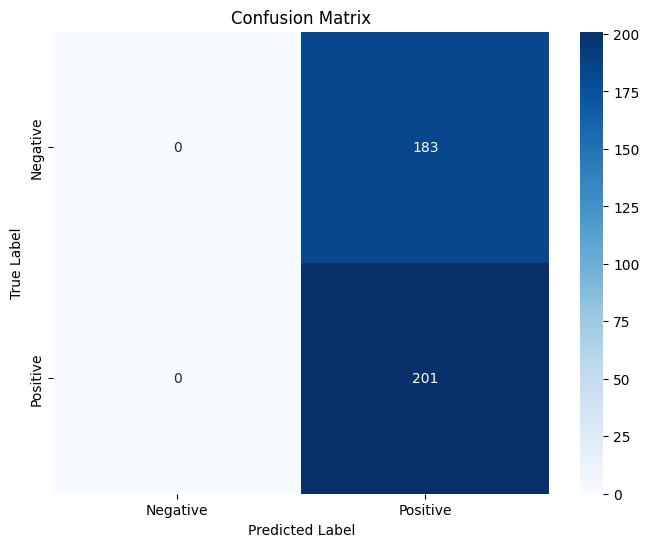

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels for the validation set
true_labels = np.concatenate([y for x, y in train], axis=0)

# Predict labels using the hybrid model on the validation set
predicted_labels = model_with_high_dropout.predict(train)

# Convert predicted probabilities to binary labels
predicted_labels_binary = np.round(predicted_labels).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


#TSGD Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense

# Assuming 256x256 input images
input_shape = (256, 256, 3)

# Segmentation model
def create_segmentation_model():
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(pool1)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up1)

    segmentation_model = Model(inputs, decoded, name='segmentation_model')
    return segmentation_model

# Classification model
def create_classification_model():
    inputs = Input(input_shape)

    # CNN layers
    conv1 = Conv2D(16, (3, 3), activation='relu')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    flatten = Flatten()(pool3)

    # Dense layers
    dense1 = Dense(256, activation='relu')(flatten)
    output = Dense(1, activation='sigmoid')(dense1)

    classification_model = Model(inputs, output, name='classification_model')
    return classification_model

# Combined model
def create_hybrid_model():
    input_tensor = Input(input_shape)

    # Segmentation model
    segmentation_model = create_segmentation_model()
    segmentation_output = segmentation_model(input_tensor)

    # Classification model
    classification_model = create_classification_model()
    classification_output = classification_model(segmentation_output)

    hybrid_model = Model(inputs=input_tensor, outputs=classification_output, name='hybrid_model')
    return hybrid_model

# Compile the hybrid model
hybrid_model = create_hybrid_model()
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the hybrid model architecture
hybrid_model.summary()


Model: "hybrid_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 segmentation_model (Functi  (None, 256, 256, 3)       1763      
 onal)                                                           
                                                                 
 classification_model (Func  (None, 1)                 14769697  
 tional)                                                         
                                                                 
Total params: 14771460 (56.35 MB)
Trainable params: 14771460 (56.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 7. Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = hybrid_model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/25
12/12 [==============================] - 150s 11s/step - loss: 1.1952 - accuracy: 0.4844 - val_loss: 0.7097 - val_accuracy: 0.4750
Epoch 2/25
12/12 [==============================] - 142s 11s/step - loss: 0.6960 - accuracy: 0.5260 - val_loss: 0.7009 - val_accuracy: 0.4563
Epoch 3/25
12/12 [==============================] - 142s 11s/step - loss: 0.6996 - accuracy: 0.4948 - val_loss: 0.6916 - val_accuracy: 0.5063
Epoch 4/25
12/12 [==============================] - 142s 11s/step - loss: 0.6896 - accuracy: 0.5208 - val_loss: 0.6793 - val_accuracy: 0.5312
Epoch 5/25
12/12 [==============================] - 130s 10s/step - loss: 0.6719 - accuracy: 0.5391 - val_loss: 0.6746 - val_accuracy: 0.4812
Epoch 6/25
12/12 [==============================] - 143s 11s/step - loss: 0.6333 - accuracy: 0.6484 - val_loss: 0.6463 - val_accuracy: 0.6687
Epoch 7/25
12/12 [==============================] - 143s 11s/step - loss: 0.5995 - accuracy: 0.7057 - val_loss: 0.5612 - val_accuracy: 0.7437
Epoch 

In [ ]:
hist = hybrid_model.fit(train, epochs=2, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/2
12/12 [==============================] - 131s 9s/step - loss: 0.0609 - accuracy: 0.9818 - val_loss: 0.0367 - val_accuracy: 0.9937
Epoch 2/2
12/12 [==============================] - 133s 10s/step - loss: 0.0621 - accuracy: 0.9766 - val_loss: 0.0299 - val_accuracy: 0.9812


# 8. Plot Performance

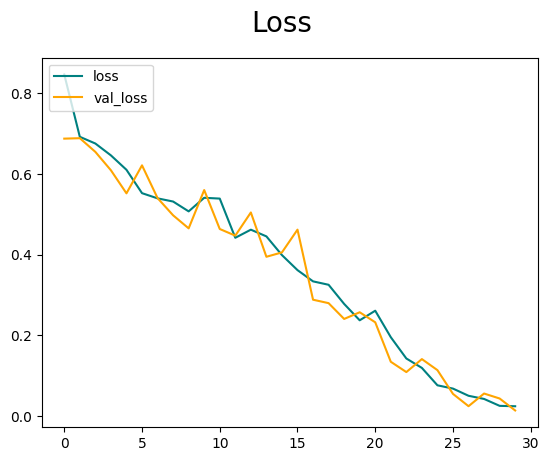

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

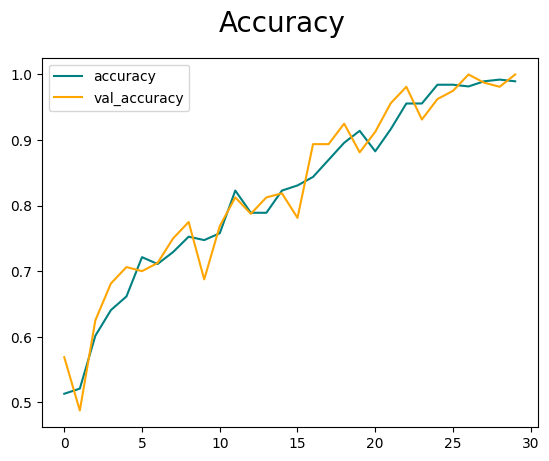

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

CM after 25 epochs

12/12 [==============================] - 51s 2s/step


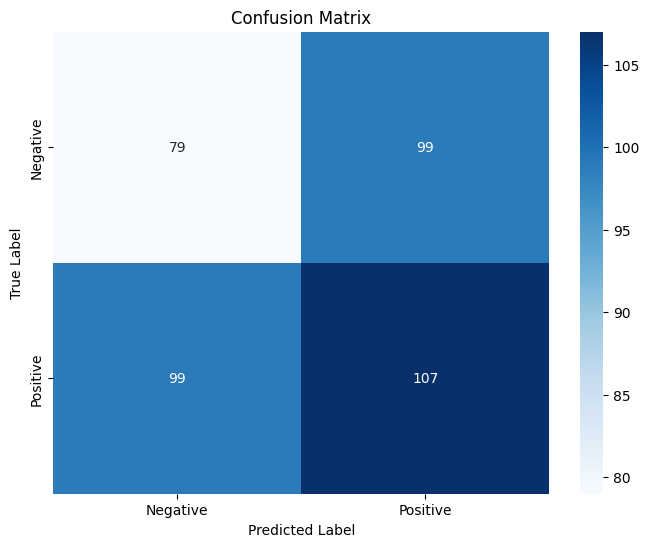

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels for the validation set
true_labels = np.concatenate([y for x, y in train], axis=0)

# Predict labels using the hybrid model on the validation set
predicted_labels = hybrid_model.predict(train)

# Convert predicted probabilities to binary labels
predicted_labels_binary = np.round(predicted_labels).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Verify the shape and content of true labels
print("True Labels Shape:", true_labels.shape)
print("True Labels:", true_labels)

True Labels Shape: (160,)
True Labels: [0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0
 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0
 1 0 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 1
 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1
 1 1 1 0 1 1 0 1 0 1 0 1]


# 9. Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in val.as_numpy_iterator():
    X, y = batch
    yhat = hybrid_model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 1s/step


In [ ]:
precision = pre.result().numpy()
recall = re.result().numpy()
accuracy = acc.result().numpy()

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

Precision: 0.94871795
Recall: 1.0
Accuracy: 0.975
F1 Score: 0.9736842121361365


# 10. Test

In [ ]:
import cv2

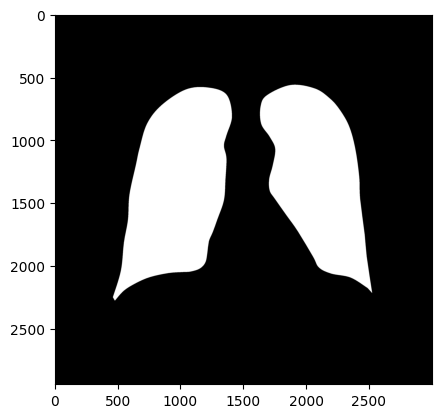

In [ ]:
img = cv2.imread('/content/drive/MyDrive/dataaa/test0.png')
plt.imshow(img)
plt.show()

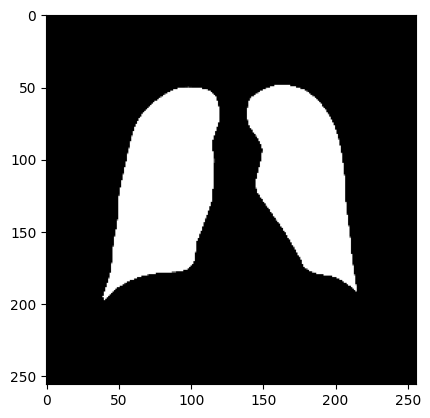

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = hybrid_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 84ms/step


In [ ]:
yhat

array([[0.13571739]], dtype=float32)

1/1 [==============================] - 0s 179ms/step


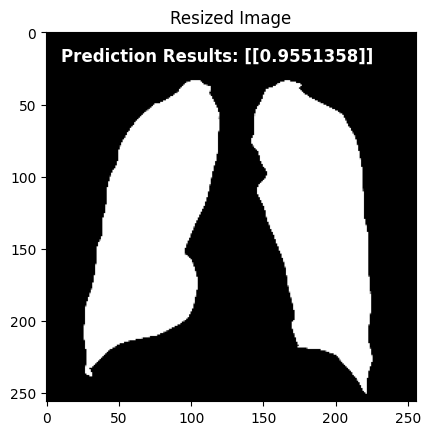

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load the image
img = cv2.imread('/content/drive/MyDrive/dataaa/test1.png')

# Resize the image
resize = tf.image.resize(img, (256, 256))

# Preprocess the image
preprocessed_img = np.expand_dims(resize / 255, 0)

# Predict using the model
yhat = hybrid_model.predict(preprocessed_img)

# Plot the image
plt.imshow(resize.numpy().astype(int))
plt.title('Resized Image')

# Add text for prediction results
plt.text(10, 20, f'Prediction Results: {yhat}', color='white', fontsize=12, fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))

plt.show()


1/1 [==============================] - 0s 218ms/step


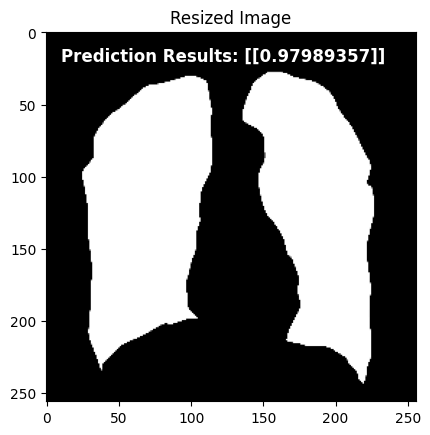

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load the image
img = cv2.imread('/content/drive/MyDrive/dataaa/test1.1.png')

# Resize the image
resize = tf.image.resize(img, (256, 256))

# Preprocess the image
preprocessed_img = np.expand_dims(resize / 255, 0)

# Predict using the model
yhat = hybrid_model.predict(preprocessed_img)

# Plot the image
plt.imshow(resize.numpy().astype(int))
plt.title('Resized Image')

# Add text for prediction results
plt.text(10, 20, f'Prediction Results: {yhat}', color='white', fontsize=12, fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))

plt.show()


1/1 [==============================] - 0s 70ms/step


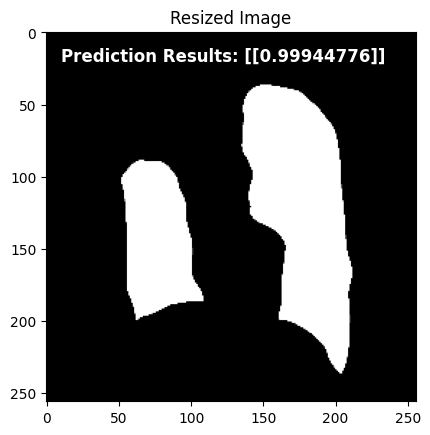

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load the image
img = cv2.imread('/content/drive/MyDrive/dataaa/test1.2.png')

# Resize the image
resize = tf.image.resize(img, (256, 256))

# Preprocess the image
preprocessed_img = np.expand_dims(resize / 255, 0)

# Predict using the model
yhat = hybrid_model.predict(preprocessed_img)

# Plot the image
plt.imshow(resize.numpy().astype(int))
plt.title('Resized Image')

# Add text for prediction results
plt.text(10, 20, f'Prediction Results: {yhat}', color='white', fontsize=12, fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))

plt.show()


1/1 [==============================] - 0s 77ms/step


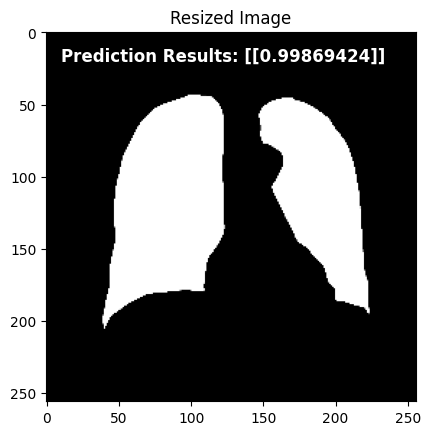

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load the image
img = cv2.imread('/content/drive/MyDrive/dataaa/test1.3.png')

# Resize the image
resize = tf.image.resize(img, (256, 256))

# Preprocess the image
preprocessed_img = np.expand_dims(resize / 255, 0)

# Predict using the model
yhat = hybrid_model.predict(preprocessed_img)

# Plot the image
plt.imshow(resize.numpy().astype(int))
plt.title('Resized Image')

# Add text for prediction results
plt.text(10, 20, f'Prediction Results: {yhat}', color='white', fontsize=12, fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))

plt.show()


1/1 [==============================] - 0s 97ms/step


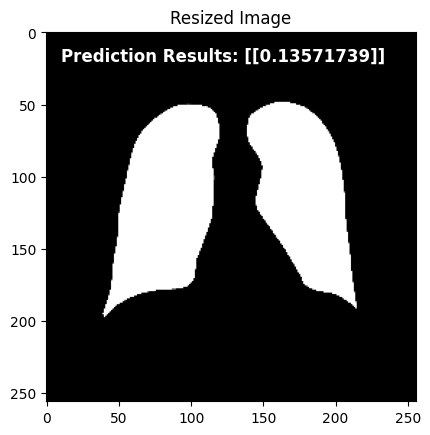

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load the image
img = cv2.imread('/content/drive/MyDrive/dataaa/test0.png')

# Resize the image
resize = tf.image.resize(img, (256, 256))

# Preprocess the image
preprocessed_img = np.expand_dims(resize / 255, 0)

# Predict using the model
yhat = hybrid_model.predict(preprocessed_img)

# Plot the image
plt.imshow(resize.numpy().astype(int))
plt.title('Resized Image')

# Add text for prediction results
plt.text(10, 20, f'Prediction Results: {yhat}', color='white', fontsize=12, fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))

plt.show()


1/1 [==============================] - 0s 81ms/step


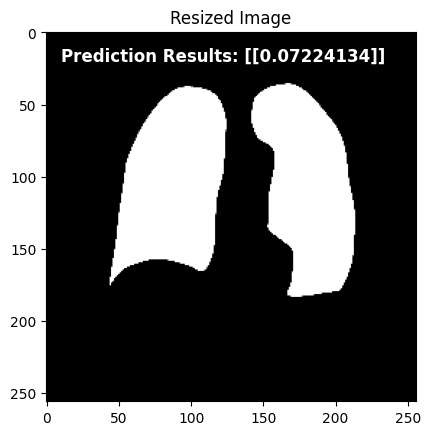

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load the image
img = cv2.imread('/content/drive/MyDrive/dataaa/test0.1.png')

# Resize the image
resize = tf.image.resize(img, (256, 256))

# Preprocess the image
preprocessed_img = np.expand_dims(resize / 255, 0)

# Predict using the model
yhat = hybrid_model.predict(preprocessed_img)

# Plot the image
plt.imshow(resize.numpy().astype(int))
plt.title('Resized Image')

# Add text for prediction results
plt.text(10, 20, f'Prediction Results: {yhat}', color='white', fontsize=12, fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))

plt.show()


1/1 [==============================] - 0s 186ms/step


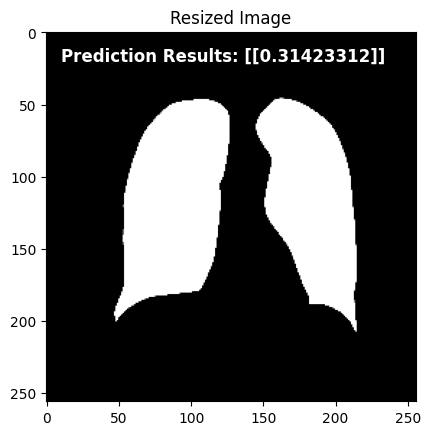

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load the image
img = cv2.imread('/content/drive/MyDrive/dataaa/test0.2.png')

# Resize the image
resize = tf.image.resize(img, (256, 256))

# Preprocess the image
preprocessed_img = np.expand_dims(resize / 255, 0)

# Predict using the model
yhat = hybrid_model.predict(preprocessed_img)

# Plot the image
plt.imshow(resize.numpy().astype(int))
plt.title('Resized Image')

# Add text for prediction results
plt.text(10, 20, f'Prediction Results: {yhat}', color='white', fontsize=12, fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))

plt.show()


1/1 [==============================] - 0s 75ms/step


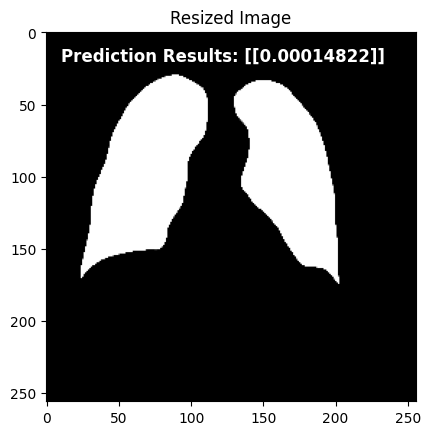

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load the image
img = cv2.imread('/content/drive/MyDrive/dataaa/test0.3.png')

# Resize the image
resize = tf.image.resize(img, (256, 256))

# Preprocess the image
preprocessed_img = np.expand_dims(resize / 255, 0)

# Predict using the model
yhat = hybrid_model.predict(preprocessed_img)

# Plot the image
plt.imshow(resize.numpy().astype(int))
plt.title('Resized Image')

# Add text for prediction results
plt.text(10, 20, f'Prediction Results: {yhat}', color='white', fontsize=12, fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))

plt.show()


In [ ]:
if yhat > 0.5:
    print(f'Predicted class is contageious')
else:
    print(f'Predicted class is normal')

Predicted class is normal


# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
hybrid_model.save(os.path.join('models','/content/drive/MyDrive/dataaa/tuberculosis/imageclassifier1.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
new_model = load_model('/content/drive/MyDrive/dataaa/tuberculosis/imageclassifier1.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 190ms/step


array([[0.9994838]], dtype=float32)